# Adadelta

除了 RMSProp 以外，另一个常用优化算法 Adadelta 也针对 Adagrad 在迭代后期可能较难找到有用解的问题做了改进 [1]。有意思的是，Adadelta 没有学习率这一超参数。

## 算法

Adadelta 算法也像 RMSProp 一样，使用了小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方的指数加权移动平均变量 $\boldsymbol{s}_t$。在时间步 0，它的所有元素被初始化为 0。
给定超参数 $0 \leq \rho < 1$（对应 RMSProp 中的 $\gamma$），在时间步 $t>0$，同 RMSProp 一样计算

$$\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

与 RMSProp 不同的是，Adadelta 还维护一个额外的状态变量 $\Delta\boldsymbol{x}_t$，其元素同样在时间步 0 时被初始化为 0。我们使用 $\Delta\boldsymbol{x}_{t-1}$ 来计算自变量的变化量：

$$ \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t, $$

其中 $\epsilon$ 是为了维持数值稳定性而添加的常数，例如 $10^{-5}$。接着更新自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t. $$

最后，我们使用 $\Delta\boldsymbol{x}$ 来记录自变量变化量 $\boldsymbol{g}'$ 按元素平方的指数加权移动平均：

$$\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t. $$

可以看到，如不考虑 $\epsilon$ 的影响，Adadelta 跟 RMSProp 不同之处在于使用 $\sqrt{\Delta\boldsymbol{x}_{t-1}}$ 来替代超参数 $\eta$。


## 从零开始实现

Adadelta 需要对每个自变量维护两个状态变量，$\boldsymbol{s}_t$ 和 $\Delta\boldsymbol{x}_t$。我们按算法中的公式实现 Adadelta。

In [1]:
%matplotlib inline
import gluonbook as gb
from mxnet import nd

features, labels = gb.get_data_ch7()

def init_adadelta_states():
    s_w, s_b = nd.zeros((features.shape[1], 1)), nd.zeros(1)
    delta_w, delta_b = nd.zeros((features.shape[1], 1)), nd.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * p.grad.square()
        g = ((delta + eps).sqrt() / (s + eps).sqrt()) * p.grad
        p[:] -= g
        delta[:] = rho * delta + (1 - rho) * g * g

使用超参数 $\rho=0.9$ 来训练模型。

loss: 0.243291, 0.333004 sec per epoch


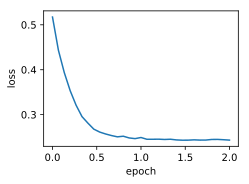

In [2]:
gb.train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

## Gluon 实现

通过算法名称为“adadelta”的`Trainer`实例，我们便可在 Gluon 中使用 Adadelta 算法。它的超参数可以通过`rho`来指定。

loss: 0.246385, 0.560817 sec per epoch


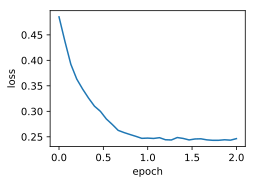

In [3]:
gb.train_gluon_ch7('adadelta', {'rho': 0.9}, features, labels)

## 小结

* Adadelta 没有学习率超参数，它通过使用有关自变量更新量平方的指数加权移动平均的项来替代学习率。

## 练习

* 调节 $\rho$ 的值，观察实验结果。

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2277)

![](../img/qr_adadelta.svg)

## 参考文献

[1] Zeiler, M. D. (2012). ADADELTA: an adaptive learning rate method. arXiv preprint arXiv:1212.5701.